In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input_data):
        raise NotImplementedError

    def backward(self, output_error, learning_rate):
        raise NotImplementedError

class FCLayer(Layer):
    def __init__(self, input_size, output_size):
        self.weight = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    def forward(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weight) + self.bias
        return self.output

    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weight.T)
        weights_error = np.dot(self.input.T, output_error)
        self.weight -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
        
    def forward(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backward(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1-np.tanh(x)**2

def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    def add(self, layer):
        self.layers.append(layer)

    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, input_data):
        samples = len(input_data)
        result = []
        for i in range(samples):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward(output)
            result.append(output)
        return result

    def train(self, x_train, y_train, epochs, learning_rate):
        samples = len(x_train)
        for i in range(epochs):
            err = 0
            start = time.perf_counter()
            for j in range(samples):
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward(output)
                err += self.loss(y_train[j], output)

                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward(error, learning_rate)

            err /= samples
            end = time.perf_counter()
            print('epochs %d/%d error=%f time=%fs' % (i+1, epochs, err, (end - start)))
        print('done training.')

In [3]:
# SOLVE XOR
x_train_xor = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train_xor = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
net.train(x_train_xor, y_train_xor, epochs=10, learning_rate=0.3)

# test
out = net.predict(x_train_xor)
print(out)

epochs 1/10 error=0.554091 time=0.000596s
epochs 2/10 error=0.377736 time=0.000314s
epochs 3/10 error=0.365646 time=0.000272s
epochs 4/10 error=0.356542 time=0.000643s
epochs 5/10 error=0.347968 time=0.000257s
epochs 6/10 error=0.338654 time=0.000331s
epochs 7/10 error=0.327968 time=0.000234s
epochs 8/10 error=0.315637 time=0.000311s
epochs 9/10 error=0.301808 time=0.000222s
epochs 10/10 error=0.287254 time=0.000218s
done training.
[array([[0.24133164]]), array([[0.78819522]]), array([[0.70752773]]), array([[0.86551828]])]


In [4]:
# MNIST Dataset in CSV Format
# !curl -O https://pjreddie.com/media/files/mnist_train.csv
# !curl -O https://pjreddie.com/media/files/mnist_test.csv

In [5]:
# open training file
data_file = open("mnist_train.csv", "r")
data_list = data_file.readlines()
data_file.close()
# open test file
test_file = open("mnist_test.csv", "r")
test_list = test_file.readlines()
test_file.close()

In [6]:
# convert to matrix
# x_train is the data
# y_train is the target output
data = []
expected = []
for record in data_list[:]:
    one = np.array(record.split(','))
    outputs = np.zeros(10)
    outputs[int(one[0])] = 1
    expected.append(outputs)
    data.append(one[1:])

data_test = []
expected_test = []
for record in test_list[:]:
    one = np.array(record.split(','))
    outputs = np.zeros(10)
    outputs[int(one[0])] = 1
    expected_test.append(outputs)
    data_test.append(one[1:])


In [7]:
# Convert to np.array and reshape to make it feedable to net.
x_train = np.array(data).reshape(-1, 1, 28*28).astype('float32')
y_train = np.array(expected)
x_test  = np.array(data_test).reshape(-1, 1, 28*28).astype('float32')
y_test  = np.array(expected_test)

In [8]:
x_train.shape, y_train.shape

((60000, 1, 784), (60000, 10))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
label 5


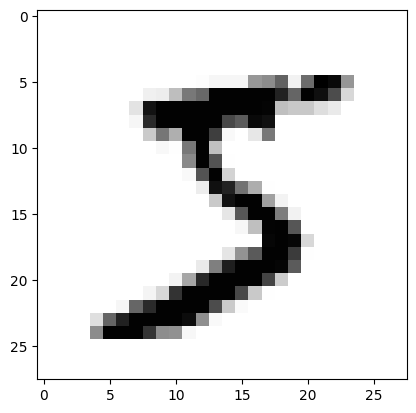

In [9]:
# Try to plot the image
def plot_image(image):
    grid = np.asarray(image).reshape((28, 28))
    plt.imshow(grid, cmap="Greys", interpolation="None")

print(y_train[0])
print("label", y_train.argmax())
plot_image(x_train[0])

In [10]:
# Define the network
net = Network()
net.add(FCLayer(28*28, 100))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(100, 50))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(50, 10))
net.add(ActivationLayer(tanh, tanh_prime))
net.use(mse, mse_prime)
# Train it!
net.train(x_train / 255.0 * .99, y_train, epochs=5, learning_rate=0.3)

epochs 1/5 error=0.093481 time=20.707246s
epochs 2/5 error=0.029142 time=22.728903s
epochs 3/5 error=0.022763 time=20.941150s
epochs 4/5 error=0.020065 time=19.332913s
epochs 5/5 error=0.018320 time=17.502973s
done training.


In [11]:
# Retrain...
net.train(x_train / 255.0 * .99, y_train, epochs=5, learning_rate=0.3)

epochs 1/5 error=0.017191 time=17.513238s
epochs 2/5 error=0.016444 time=17.616057s
epochs 3/5 error=0.015183 time=17.792964s
epochs 4/5 error=0.015092 time=18.013322s
epochs 5/5 error=0.014326 time=17.542600s
done training.


In [12]:
# Test the network on the unseen
out = net.predict(x_test)
out = np.array(out)
total = x_test.shape[0]
correct = 0
for i in range(out.shape[0]):
    # argmax get index of max value in array, the index represent the actual and expected number
    actual = out[i].argmax()
    expected = y_test[i].argmax()
    # print(i, "actual:", actual, " | expected:", expected)
    if actual == expected:
        correct += 1

print('accuracy:', correct / total)

accuracy: 0.9364


actual: 9 expected: 9
[[ 3.92797137e-02  5.65135769e-03  1.20461473e-02  2.83622999e-02
  -1.79536146e-02 -9.84831330e-03 -3.81840538e-04  3.95843705e-03
   7.28334500e-03  9.03130240e-01]]


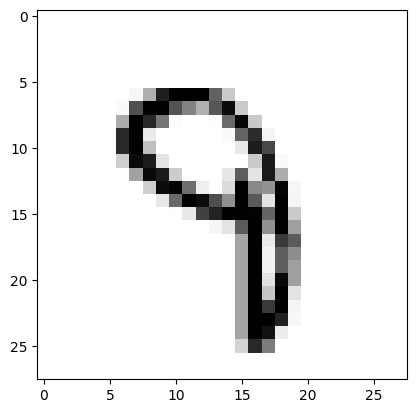

In [13]:
# Predict one of the "hardest" number to read by me
index = 193
plot_image(x_test[index])
[out_one] = net.predict(x_test[index:index+1])
print("actual:", out_one.argmax(), "expected:", y_test[index].argmax())
print(out_one)